Importing libraries and Resnet 18

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import skimage
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import gc
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch.optim as optim
import joblib

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model and image processor
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-18").to(device)


c:\Users\Eren\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Using device: cpu


Drawing dog pictures

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
(10222, 2)


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_95108\1110807623.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, i + 1)


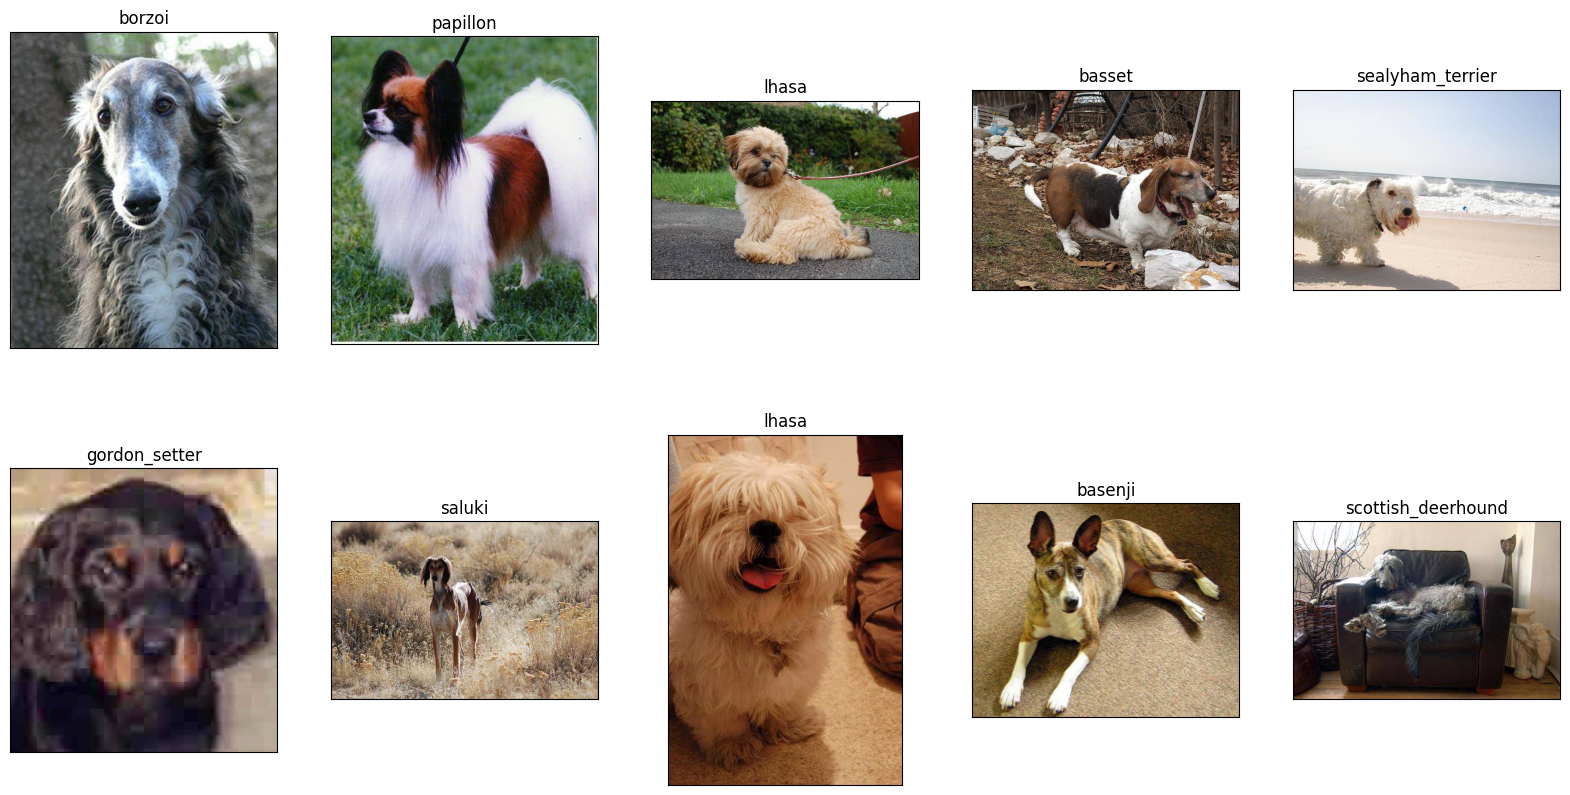

In [3]:
# Load the dataset
df = pd.read_csv('labels.csv')
print(df.head())
print(df.shape)

# Function to display images
def disp_image(im):
    im1 = (im - np.min(im)) / (np.max(im) - np.min(im)) * 255
    im1 = im1.astype(np.uint8)
    plt.imshow(im1)
    plt.xticks([])
    plt.yticks([])

plt.subplots(figsize=(20, 10))
plt.axis('off')
for i in range(10):
    plt.subplot(2, 5, i + 1)
    k = np.random.randint(low=0, high=df.shape[0])
    fname = 'train/' + df['id'][k] + '.jpg'
    im_color = skimage.io.imread(fname)
    disp_image(im_color)
    plt.title(df.loc[k, 'breed'])


Preprocessing images

In [4]:
# Encode labels
le = preprocessing.LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])




# Preprocess images
inputs = []  # List of tensors for each image
for im in range(df.shape[0]):
    fname = 'train/' + df['id'][im] + '.jpg'
    input_image = skimage.io.imread(fname)
    input_tensor = image_processor(input_image, return_tensors="pt")["pixel_values"][0]
    inputs.append(input_tensor)

print(inputs[0].shape)  # Check the shape of the first tensor

# Create tensors for input and labels
input_batch = torch.stack(inputs).to(device)
labels = torch.tensor(df['breed'].values, dtype=torch.int64).to(device)
print(input_batch.shape)
print(labels.shape)

# Split into train and test sets
xtr, xts, ytr, yts = train_test_split(input_batch, labels, test_size=0.15, random_state=42)


torch.Size([3, 224, 224])
torch.Size([10222, 3, 224, 224])
torch.Size([10222])


transfer learning


In [5]:
# Update model for 120 classes
num_classes = 120
classifier = model.classifier[-1]  # Last layer
model.classifier[-1] = nn.Linear(classifier.in_features, num_classes)

# Freeze all layers except the last layer
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)
print(model)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): Identity()
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activation): ReLU()
           

Creating dataloader


In [6]:
# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(xtr, ytr)
test_dataset = TensorDataset(xts, yts)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Training model

In [7]:
# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize lists to store metrics
train_accuracy_history = []
test_accuracy_history = []
loss_history = []

# Training loop
epochs = 15
for epoch in range(epochs):
    gc.collect()
    torch.cuda.empty_cache()

    # Training phase
    model.train()
    correct, total, epoch_loss = 0, 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.logits, target)
        loss.backward()
        optimizer.step()

        # Top-2 accuracy
        _, top2_predicted = torch.topk(outputs.logits, 2, dim=1)
        total += target.size(0)
        correct += (top2_predicted == target.unsqueeze(1)).sum().item()
        epoch_loss += loss.item()

    train_accuracy = 100 * correct / total
    train_accuracy_history.append(train_accuracy)
    loss_history.append(epoch_loss / len(train_loader))

    # Testing phase
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, top2_predicted = torch.topk(outputs.logits, 2, dim=1)
            total += target.size(0)
            correct += (top2_predicted == target.unsqueeze(1)).sum().item()

    test_accuracy = 100 * correct / total
    test_accuracy_history.append(test_accuracy)

    # Print epoch metrics
    print(f'Epoch [{epoch+1}/{epochs}]')
    print(f'  Loss: {epoch_loss:.4f}')
    print(f'  Train Accuracy: {train_accuracy:.2f}%')
    print(f'  Test Accuracy: {test_accuracy:.2f}%\n')

    scheduler.step()

print("Training complete!")


Epoch [1/15]
  Loss: 697.2162
  Train Accuracy: 58.55%
  Test Accuracy: 83.25%

Epoch [2/15]
  Loss: 303.6784
  Train Accuracy: 86.52%
  Test Accuracy: 86.31%

Epoch [3/15]
  Loss: 224.5786
  Train Accuracy: 90.50%
  Test Accuracy: 86.83%

Epoch [4/15]
  Loss: 184.3592
  Train Accuracy: 92.48%
  Test Accuracy: 86.64%

Epoch [5/15]
  Loss: 159.5307
  Train Accuracy: 93.78%
  Test Accuracy: 87.16%

Epoch [6/15]
  Loss: 122.8759
  Train Accuracy: 96.39%
  Test Accuracy: 88.07%

Epoch [7/15]
  Loss: 118.3220
  Train Accuracy: 96.67%
  Test Accuracy: 88.53%

Epoch [8/15]
  Loss: 117.4542
  Train Accuracy: 96.85%
  Test Accuracy: 87.81%

Epoch [9/15]
  Loss: 115.5706
  Train Accuracy: 96.71%
  Test Accuracy: 88.46%

Epoch [10/15]
  Loss: 114.5589
  Train Accuracy: 96.97%
  Test Accuracy: 88.79%

Epoch [11/15]
  Loss: 110.7186
  Train Accuracy: 97.17%
  Test Accuracy: 88.92%

Epoch [12/15]
  Loss: 109.5071
  Train Accuracy: 97.44%
  Test Accuracy: 88.66%

Epoch [13/15]
  Loss: 108.7762
  Trai

Saving Model And looking at how training went

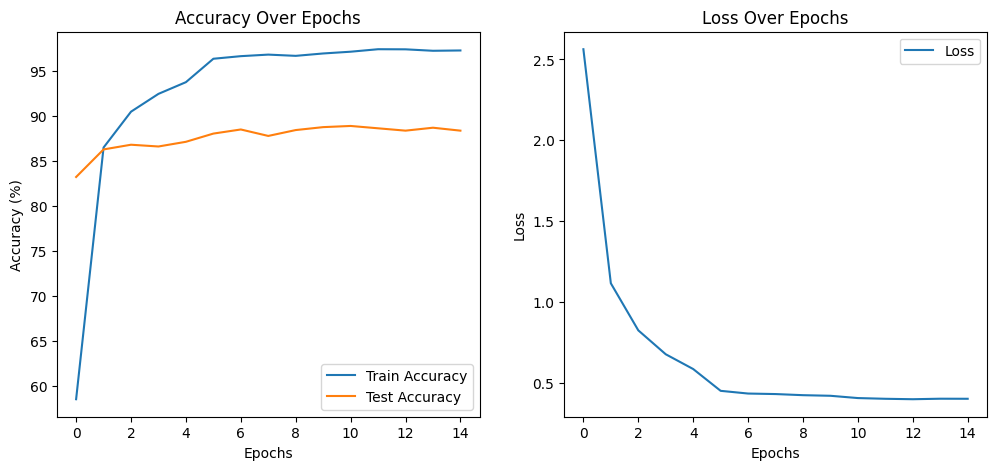

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): Identity()
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activation): ReLU()
           

In [8]:
# Save model
torch.save(model, 'model_imp_v2.pth')

# Plot metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_history, label="Train Accuracy")
plt.plot(test_accuracy_history, label="Test Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")

plt.subplot(1, 2, 2)
plt.plot(loss_history, label="Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()


joblib.dump(le, 'label_encoder.pkl')

print(model)